Inspired from https://medium.com/@emvnagakarthik/linear-regression-with-pytorch-e122a4f9d96c

In [1]:
import sys; sys.path.insert(0, '../..')

%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from src.utils.Constants import NB_EPOCH, NB_RUN, DEVICE_TYPE, LR, BATCH_SIZE, NB_WORKERS
from src.utils.Utilities import pickle_loader, pickle_saver
from src.deeplearning.Compression import QuantizationCompressor
from src.deeplearning.Utilities import single_run_descent, multiple_run_descent, ResultsOfSeveralDescents
from src.deeplearning.Parameters import Parameters
from src.deeplearning.FederatedLearningAlgo import *

torch.manual_seed(1234)


filename = "mnist"

In [2]:
# Defining a function for plotting the line

def plot1D(model,dataset,n=0):
      
    w1 = model.state_dict()['linear.weight'].numpy()[0][0]
    b = model.state_dict()['linear.bias'].numpy()
    
    x1 = dataset.x[:,0].view(-1,1).numpy()
    y = dataset.y.numpy()
    
    yhat = w1*x1 + b
    
    # plotting
    fig = plt.figure()
    
    plt.plot(x1[:,0],  y[:,0], 'ro', label = 'y')
    plt.plot(x1[:,0],  yhat[:,0])
    plt.title('Estimated line, iteration: '+ str(n))
    plt.show()

In [3]:
# Defining a function for plotting the plane

def plot2D(model,dataset,n=0):
      
    w1 = model.state_dict()['linear.weight'].numpy()[0][0]
    w2 = model.state_dict()['linear.weight'].numpy()[0][1]
    b = model.state_dict()['linear.bias'].numpy()
    
    x1 = dataset.x[:,0].view(-1,1).numpy()
    x2 = dataset.x[:,1].view(-1,1).numpy()
    y = dataset.y.numpy()
    X,Y = np.meshgrid(np.arange(x1.min(),x1.max(),0.05),np.arange(x2.min(), x2.max(), 0.05))
    
    yhat = w1*X + w2*Y + b
    
    # plotting
    fig = plt.figure()
    ax = fig.gca(projection = '3d')
    
    ax.plot(x1[:,0], x2[:,0], y[:,0], 'ro', label = 'y')
    ax.plot_surface(X,Y,yhat)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    plt.title('Estimated plane iteration: '+ str(n))
    plt.show()

In [4]:
from src.deeplearning.ToyDataset import Data2d, Data1d
my_data = Data1d()

In [5]:


traindata_split = torch.utils.data.random_split(my_data, 
                                                [int(len(my_data) / NB_WORKERS) for _ in range(NB_WORKERS)])

# Creating a pytorch loader for a Deep Learning model
loaders = [torch.utils.data.DataLoader(my_data, batch_size=2, drop_last=True) for i in range(NB_WORKERS)]

# Attention, si je ne SHUFFLE pas,on prend toujours le même éléments -1 !!!! shuffle=True


In [6]:
len(loaders[0])

200

In [7]:
x, y = traindata_split[0][1]

In [8]:
loaders[0].dataset

In [9]:
next(cycle(loaders[0]))

[tensor([[-1.0000],
         [-0.9950]]),
 tensor([[-0.0001],
         [ 0.0045]])]

In [10]:
loaders[0].dataset

In [11]:
len(loaders[0])

200

In [12]:
%%time
fl_algo = single_run_descent(VanillaSGD, Parameters(model_id="LinReg", nb_epoch=10, 
                                                    verbose=True, batch_size=loaders[0].batch_size), loaders)
print("---> final loss:", fl_algo.losses[-1])
print("---> final metrics:", fl_algo.metrics[-1])
obj_min = fl_algo.losses[-1]
pickle_saver(obj_min, filename + "-obj_min")

/home/constantin/anaconda3/envs/artemis/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


   it    |   obj    |   acc   
       2 | 2.1085e+01 | -8.4815e-02
       4 | 1.5158e-01 | -8.8040e-02
       6 | 3.7504e-03 | -8.2872e-02
       8 | 2.7032e-03 | -8.8865e-02
---> final loss: 0.0026958110788655176
---> final metrics: -0.08644634085080022
CPU times: user 2min 43s, sys: 98.9 ms, total: 2min 43s
Wall time: 2min 43s


After training: 
OrderedDict([('linear.weight', tensor([[0.9999]])), ('linear.bias', tensor([1.0000]))])


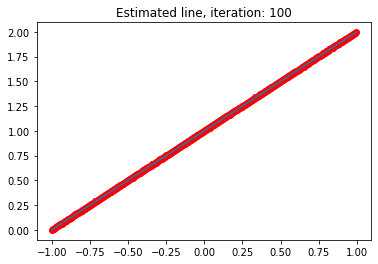

In [13]:
print("After training: ")
print(fl_algo.learners[0].model.state_dict())
plot1D(fl_algo.learners[0].model, my_data, 100)